## Libraries & Dataset

In [1]:
# The Libraries used
import torch
import torch.nn as nn
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from google.colab import files
import io
from sklearn.preprocessing import MinMaxScaler

In [2]:
data=files.upload()

Saving Amazon_Stock_2006-01-01_to_2018-01-01.csv to Amazon_Stock_2006-01-01_to_2018-01-01.csv


In [3]:
df=pd.read_csv(io.StringIO(data['Amazon_Stock_2006-01-01_to_2018-01-01.csv'].decode('utf-8'))) # Reading the CSV File 

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


## The Stock Plot

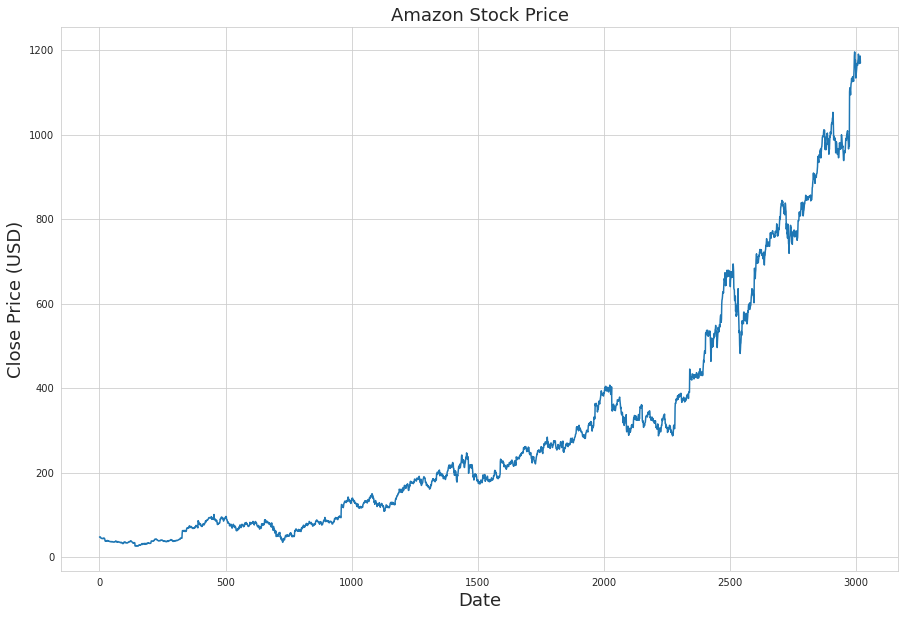

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize = (15,10))
plt.plot(df[['Close']])
plt.title("Amazon Stock Price",fontsize=18) 
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [6]:
df.isnull().sum() # No Missing Values

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [7]:
df.size # The Number of Stocks

21133

## Normalizing Data

In [8]:
price= df[['Close']] # For easy access of the Series within DataFrame
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 23.7 KB


In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1)) # MinMaxScaler used to Normalize Data b/w -1 to 1
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1)) 

In [10]:
def split_data(price, seq): # Function to give the Training & Test Data Split 
    y = price.to_numpy() # convert to numpy array
    x = []
    
    # Sequences of length 'seq'
    for index in range(len(y) - seq): 
        x.append(y[index: index + seq])
    
    x = np.array(x);
    test_set_size = int(np.round(0.2*x.shape[0])); # 20% of Data kept as Test Data
    train_set_size = x.shape[0] - (test_set_size); # Remaining Data is kept as Training Data
    
    # In our case we take seq=20, so we take 0-18 as 19 elements for the X_Training Data and the 20th element i.e idx=19 as the Y_Training Data(Label)
    # Similarily we do for the Test Data
    x_train = x[:train_set_size,:-1,:] 
    y_train = x[:train_set_size,-1,:]
    
    x_test = x[train_set_size:,:-1]
    y_test = x[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [11]:
seq = 20 # Sequence Length
x_train, y_train, x_test, y_test = split_data(price, seq)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


In [12]:
# Conversion of the Numpy Variables to Tensors for the LSTM & GRU Model
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [13]:
input_dim = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
num_epochs = 200

## LSTM Model

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim # Number of Features in Hidden State
        self.num_layers = num_layers # Number of Recurrent Layers i.e Number of LSTMs stacked together to form a Stacked LSTM
        
        # batch_first -> If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature).
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # 'Hidden State' & 'Cell State' are initialised to 0

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) # .detach() Returns a new Tensor that doesn't require a gradient.
        out = self.linear(out[:, -1, :]) 
        return out

In [15]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean') # reduction='mean' divides the O/P with the number of elements
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
14
torch.Size([256, 1])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([1, 64])
torch.Size([1])


In [17]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.6754831671714783
Epoch  1 MSE:  0.37003278732299805
Epoch  2 MSE:  0.045930564403533936
Epoch  3 MSE:  1.2094794511795044
Epoch  4 MSE:  0.28375890851020813
Epoch  5 MSE:  0.04190494865179062
Epoch  6 MSE:  0.11976935714483261
Epoch  7 MSE:  0.15937979519367218
Epoch  8 MSE:  0.16475479304790497
Epoch  9 MSE:  0.1548684984445572
Epoch  10 MSE:  0.1390557438135147
Epoch  11 MSE:  0.12119200825691223
Epoch  12 MSE:  0.10278154909610748
Epoch  13 MSE:  0.08455448597669601
Epoch  14 MSE:  0.06724397093057632
Epoch  15 MSE:  0.05214143171906471
Epoch  16 MSE:  0.041915252804756165
Epoch  17 MSE:  0.04187420755624771
Epoch  18 MSE:  0.05212372913956642
Epoch  19 MSE:  0.054115038365125656
Epoch  20 MSE:  0.049064308404922485
Epoch  21 MSE:  0.044036976993083954
Epoch  22 MSE:  0.04133724421262741
Epoch  23 MSE:  0.04056309908628464
Epoch  24 MSE:  0.040843769907951355
Epoch  25 MSE:  0.04150962457060814
Epoch  26 MSE:  0.04215220361948013
Epoch  27 MSE:  0.042562421411275864

In [18]:
predict1 = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original1 = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

In [19]:
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

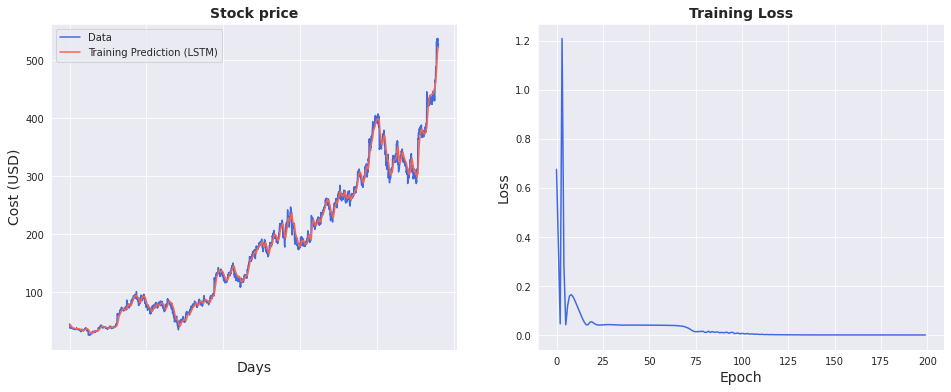

In [20]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original1.index, y = original1[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict1.index, y = predict1[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [21]:
print(calculate_accuracy(original1,predict1))

93.97762902081013


## GRU Model

In [22]:
class GRU(nn.Module): # Gated Recurrent Unit
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [23]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [24]:
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

GRU(
  (gru): GRU(1, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
14
torch.Size([192, 1])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([192, 64])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([192, 64])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([1, 64])
torch.Size([1])


In [25]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.7529389262199402
Epoch  1 MSE:  0.038811374455690384
Epoch  2 MSE:  0.08389550447463989
Epoch  3 MSE:  0.15101921558380127
Epoch  4 MSE:  0.041568826884031296
Epoch  5 MSE:  0.09245837479829788
Epoch  6 MSE:  0.05780259519815445
Epoch  7 MSE:  0.027558717876672745
Epoch  8 MSE:  0.05111095681786537
Epoch  9 MSE:  0.04804075509309769
Epoch  10 MSE:  0.024737637490034103
Epoch  11 MSE:  0.028269032016396523
Epoch  12 MSE:  0.03841237351298332
Epoch  13 MSE:  0.03210531920194626
Epoch  14 MSE:  0.016351895406842232
Epoch  15 MSE:  0.01566251739859581
Epoch  16 MSE:  0.025432689115405083
Epoch  17 MSE:  0.01123466994613409
Epoch  18 MSE:  0.0052588097751140594
Epoch  19 MSE:  0.01474657841026783
Epoch  20 MSE:  0.008259882219135761
Epoch  21 MSE:  0.0012663622619584203
Epoch  22 MSE:  0.014555762521922588
Epoch  23 MSE:  0.002213813830167055
Epoch  24 MSE:  0.005488937720656395
Epoch  25 MSE:  0.008147424086928368
Epoch  26 MSE:  0.001597707043401897
Epoch  27 MSE:  0.0018

In [26]:
predict2 = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original2 = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

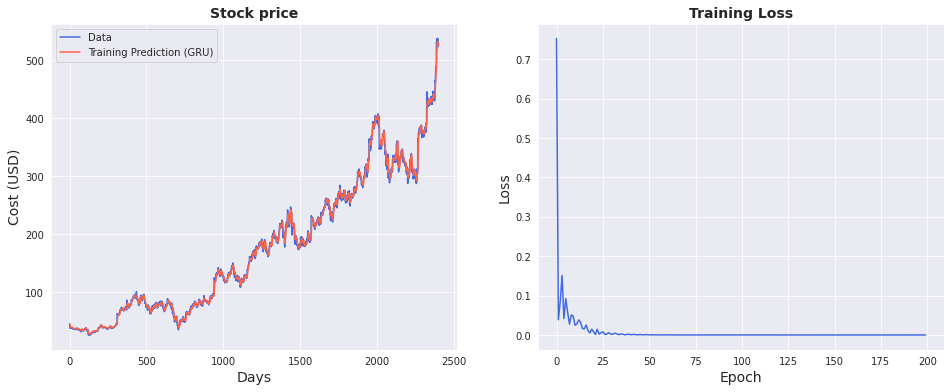

In [27]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original2.index, y = original2[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict2.index, y = predict2[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [28]:
print(calculate_accuracy(original2,predict2))

96.44177630543709


In [30]:
## Accuracies with the 2 Models
# LSTM -> 93.98%
# GRU  -> 96.44%